<a href="https://colab.research.google.com/github/w4bo/AA2425-unibo-mldm/blob/master/slides/lab-02-datapreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [68]:
import pandas as pd
import numpy as np  # fast operations on arrays
import seaborn as sns  # plots
import matplotlib.pyplot as plt  # plots

df = pd.DataFrame([
    ['Cola',   'low',    '05/07/2021', 10, 2],
    ['Bread',  'medium', '05/07/2021', 25, 1],
    ['Beer',   'high',   '06/07/2021', 100, 3],
    ['Diaper', 'high',   '06/07/2021', np.nan, 4],
    ['Pizza',  'medium', '06/07/2021', 25, 5]], columns=['ID', 'PriceBin', 'Date', 'Quantity', 'Review'])
df

,ID,PriceBin,Date,Quantity,Review
0,Cola,low,05/07/2021,10.0,2
1,Bread,medium,05/07/2021,25.0,1
2,Beer,high,06/07/2021,100.0,3
3,Diaper,high,06/07/2021,NaN,4
4,Pizza,medium,06/07/2021,25.0,5


## What transformations can we apply?

- **Encoding**: transforming categorical attributes into continuous ones
- **Discretization**: transforming continuous attributes into categorical ones
- **Normalization**: normalizing continuous attributes such that their values fall in the same range
- **Imputation**: imputing missing values
- **Rebalancing**: adjusting the class distribution of a dataset (i.e., the ratio between the different classes/categories represented)
- **Feature Engineering**: defining the set of relevant attributes (variables, predictors) to be used in model construction

# Data distribution

In [69]:
# array with distinct values sorted by first appearance
df["Quantity"].unique()

array([ 10.,  25., 100.,  nan])

In [70]:
# quantity of unique values
df["Quantity"].nunique()

3

In [71]:
# return a new series that associates each value with its number of occurrences, sorted by frequency
df["Quantity"].value_counts()

,count
Quantity,
25.0,2
10.0,1
100.0,1


<Axes: >

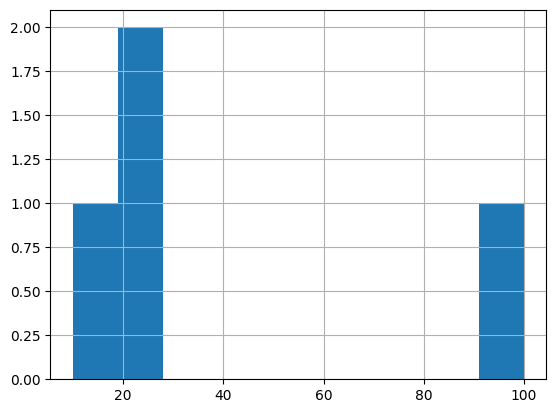

In [72]:
df["Quantity"].hist(bins=10)

## Skewed distributions

![image](https://user-images.githubusercontent.com/18005592/232750742-aacbf6b3-8a7d-49c6-b253-5ab8e7985104.png)

What problems can arise with skewed distributions?

## Sequences of transformations

Things are even more complex when applying sequences of transformations

- E.g., normalization should be applied before rebalancing since rebalancing (e.g., by resampling) alters average and standard deviations
- E.g., applying feature engineering before/after rebalancing produces different results which depends on the dataset and the algorithm

![image](https://user-images.githubusercontent.com/18005592/232754117-8a84fde5-bce2-41b1-a003-7dfa0b63f980.png)

More an art than a science
- ... At least for now


# Missing values

Datasets often show missing values
- E.g., they are not applicable (e.g., date of death) or unknown
- A series can have missing values, referred to as `NA` (Not Available)
- Numeric attributes: `NA` is `np.nan` (Not a Number)
- `nan` is never equal, greater, or lower than other values (nor itself)

        np.nan == np.nan
        False
- Numeric expressions with `nan` return `nan`

        2 * np.nan – 1
        nan
Which problems arise from missing values?

## `isna`

In [73]:
# add the column "isna", True if the value is NaN
df["isna"] = df["Quantity"].isna()
# add the column "notna", False if the value is NaN
df["notna"] = df["Quantity"].notna()
df[["Quantity", "isna", "notna"]]

,Quantity,isna,notna
0,10.0,False,True
1,25.0,False,True
2,100.0,False,True
3,NaN,True,False
4,25.0,False,True


## Imputing missing values

Several strategies

- Replace `nan` with average or median values
- Dropping rows/columns with nans

What are the effects?

What if we have temporal attributes?

In [74]:
# fill the missing value with the average
df["Quantity_imputed"] = df["Quantity"].fillna(df["Quantity"].mean())  # fillna replaces NA values
df[["Quantity", "Quantity_imputed"]]

,Quantity,Quantity_imputed
0,10.0,10.0
1,25.0,25.0
2,100.0,100.0
3,NaN,40.0
4,25.0,25.0


In [75]:
# fill the missing value with the previous (not NaN) value
df["Quantity"].ffill()

,Quantity
0,10.0
1,25.0
2,100.0
3,100.0
4,25.0


In [76]:
# fill the missing value with the following (not NaN) value
df["Quantity"].bfill()

,Quantity
0,10.0
1,25.0
2,100.0
3,25.0
4,25.0


In [77]:
df["Quantity"].dropna()

,Quantity
0,10.0
1,25.0
2,100.0
4,25.0


In [78]:
df.dropna()

,ID,PriceBin,Date,Quantity,Review,isna,notna,Quantity_imputed
0,Cola,low,05/07/2021,10.0,2,False,True,10.0
1,Bread,medium,05/07/2021,25.0,1,False,True,25.0
2,Beer,high,06/07/2021,100.0,3,False,True,100.0
4,Pizza,medium,06/07/2021,25.0,5,False,True,25.0


# Feature engineering

Feature engineering, in data science, refers to manipulation — addition, deletion, combination, mutation — of your data set to improve machine learning model training, leading to better performance and greater accuracy.

We focus on **feature selection**


## Feature selection

Feature selection is the process of selecting a subset of relevant features (variables, predictors) for use in model construction

- *Search technique* for proposing new feature subsets
- *Evaluation measure* which scores the different feature subsets

Simplest algorithm is to test each possible subset of features finding the one which minimizes the error rate

- This is an exhaustive search of the space, and is computationally intractable for all but the smallest of feature sets
- Main categories of feature selection algorithms: wrappers, filters and embedded methods

## Wappers and filters

*Wrapper methods* use a predictive model to score feature subsets

- Each new subset is used to train a model, which is tested on a hold-out set
- Counting the number of mistakes made on that hold-out set (the error rate of the model) gives the score for that subset
- As wrapper methods train a new model for each subset, they are very computationally intensive, but usually provide good results
- *Stepwise regression* adds the best feature (or deletes the worst feature) at each round

*Filter methods* use a proxy measure instead of the error rate to score a feature subset

- This measure is chosen to be fast to compute, while still capturing the usefulness of the feature set (mutual information, Pearson correlation)
- Filters are usually less computationally intensive than wrappers, but they produce a feature set which is not tuned to a specific type of predictive model
- Filter methods have also been used as a preprocessing step for wrapper methods, allowing a wrapper to be used on larger problems

## Embedded methods

*Embedded methods* perform feature selection as part of the model construction process

- The exemplar of this approach is the LASSO method for constructing a linear model, which penalizes the regression coefficients with an L1 penalty, shrinking many of them to zero
- Any features which have non-zero regression coefficients are 'selected' by the LASSO algorithm

LASSO (least absolute shrinkage and selection operator; also Lasso or LASSO) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the resulting statistical model.

-  The lasso method assumes that the coefficients of the linear model are sparse, meaning that few of them are non-zero.

[1] Katrutsa, Alexandr, and Vadim Strijov. "Comprehensive study of feature selection methods to solve multicollinearity problem according to evaluation criteria." Expert Systems with Applications 76 (2017): 1-11.

[2] Chan, Jireh Yi-Le, et al. "Mitigating the multicollinearity problem and its machine learning approach: a review." Mathematics 10.8 (2022): 1283.


# The `Housing` case study

## Setup

In [79]:
# df = pd.read_csv("datasets/2022-bbs-dsaa-housing.csv", delimiter=",")
df = pd.read_csv("https://raw.githubusercontent.com/w4bo/handsOnDataPipelines/main/materials/datasets/housing.csv", delimiter=",")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## Profiling

In [80]:
# show some statistics on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Profiling

In [81]:
df.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN


## Missing values

There are some missing values for `total_bedrooms`. What should we do?

Most Machine Learning algorithms cannot work with missing features. We have three options:

- Get rid of the corresponding districts (i.e., drop the rows)
    - `df.dropna(subset=["total_bedrooms"])`
- Get rid of the whole attribute (i.e., drop the columns)
    - `df.drop("total_bedrooms", axis=1)`
- Set the values to some value (zero, the mean, the median, etc.)
    - `df["total_bedrooms"].fillna(df["total_bedrooms"].median())`

## Non-numeric attributes

`ocean_proximity` is a text attribute so we cannot compute its median. Some options:
- Get rid of the whole attribute. (`df.drop("ocean_proximity", axis=1`)
- Change from categorical to ordinal (e.g., `NEAR BAY` = 0, `INLAND` = 1)
    - Can foresee any problem in this?
    - ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as 'bad', 'average', 'good', 'excellent'), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1).
- Change from categorical to one hot encoding
    - To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is '<1H OCEAN' (and 0 otherwise), another attribute equal to 1 when the category is 'INLAND' (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes

In [82]:
df["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


<Axes: >

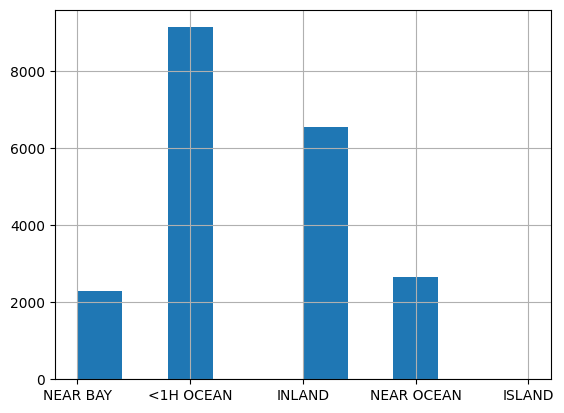

In [83]:
df["ocean_proximity"].hist()

## Encoding: ordinal


In [84]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
y = ordinal_encoder.fit_transform(df[["ocean_proximity"]])
y

array([[3.],
       [3.],
       [3.],
       ...,
       [1.],
       [1.],
       [1.]])

## Encoding: one-hot encoding

In [85]:
y = pd.get_dummies(df["ocean_proximity"], prefix='ocean_proximity')
y

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,False,True,False
3,False,False,False,True,False
4,False,False,False,True,False
...,...,...,...,...,...
20635,False,True,False,False,False
20636,False,True,False,False,False
20637,False,True,False,False,False
20638,False,True,False,False,False


## Correlation

Are there relationships between variables?


<Axes: >

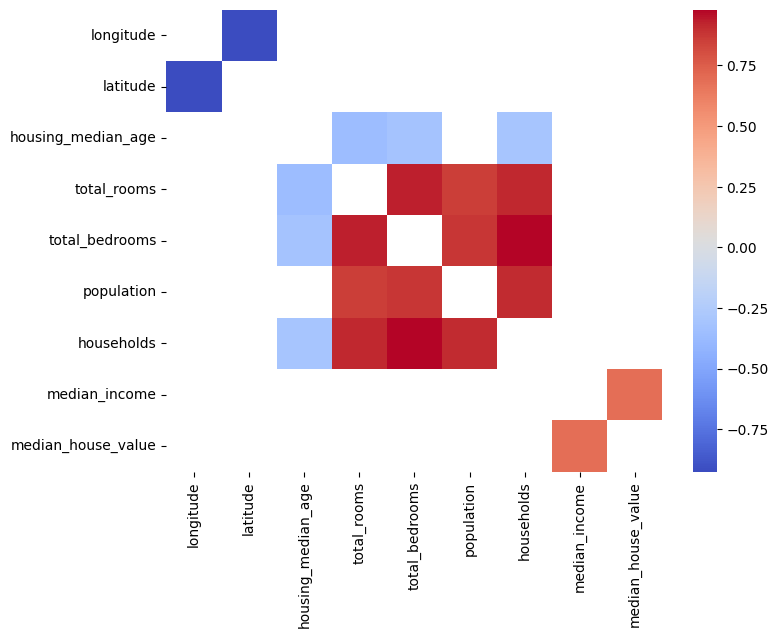

In [86]:
from scipy.stats import pearsonr
rho = df.corr(method='pearson', numeric_only=True)
min_corr = 0.3
kot = rho[(abs(rho) >= min_corr) & (rho < 1)]
plt.figure(figsize=(8, 6))
sns.heatmap(kot, cmap=sns.color_palette("coolwarm", as_cmap=True))

## Scaling attributes

Attributes have very different scales. Should we scale them?


- Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.
- Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.


## Min-max normalization

In [87]:
num_df = df.drop(columns=['ocean_proximity', 'median_house_value'])
normalized_df = (num_df - num_df.min()) / (num_df.max() - num_df.min())
normalized_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028
3,0.209163,0.564293,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699
4,0.209163,0.564293,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776
...,...,...,...,...,...,...,...,...
20635,0.324701,0.737513,0.470588,0.042296,0.057883,0.023599,0.054103,0.073130
20636,0.312749,0.738576,0.333333,0.017676,0.023122,0.009894,0.018582,0.141853
20637,0.311753,0.732200,0.313725,0.057277,0.075109,0.028140,0.071041,0.082764
20638,0.301793,0.732200,0.333333,0.047256,0.063315,0.020684,0.057227,0.094295


## Standardization

In [88]:
num_df = df.drop(columns=['ocean_proximity', 'median_house_value'])
normalized_df = (num_df - num_df.mean()) / num_df.std()
normalized_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.327803,1.052523,0.982119,-0.804800,-0.970301,-0.974405,-0.977009,2.344709
1,-1.322812,1.043159,-0.607004,2.045841,1.348243,0.861418,1.669921,2.332181
2,-1.332794,1.038478,1.856137,-0.535733,-0.825541,-0.820757,-0.843616,1.782656
3,-1.337785,1.038478,1.856137,-0.624199,-0.718750,-0.766010,-0.733764,0.932945
4,-1.337785,1.038478,1.856137,-0.462393,-0.611959,-0.759828,-0.629142,-0.012881
...,...,...,...,...,...,...,...,...
20635,-0.758808,1.801603,-0.289180,-0.444974,-0.388886,-0.512579,-0.443438,-1.216099
20636,-0.818702,1.806285,-0.845373,-0.888682,-0.920466,-0.944382,-1.008396,-0.691576
20637,-0.823693,1.778194,-0.924829,-0.174991,-0.125468,-0.369528,-0.174037,-1.142566
20638,-0.873605,1.778194,-0.845373,-0.355591,-0.305826,-0.604415,-0.393743,-1.054557
